# Clustering de documents

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [ ]:
import nltk

nltk.download('punkt')

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1960'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [ ]:
# Exemple de fichiers
files[5]

In [7]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [ ]:
# Nombre de documents
nombre_documents = len(texts)

# Afficher le nombre de documents
print("Nombre de documents:", nombre_documents)



In [ ]:
# Exemple de textes
texts[0][:400]

## Vectoriser les documents à l'aide de TF-IDF

In [10]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [11]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True) 

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [ ]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [ ]:
# Détail de la matrice
tfidf_vectors

### Imprimer le vecteur tf-IDF du premier document

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

## Comprendre les vecteurs et leurs "distances"

In [15]:
cosine([1, 2, 3], [1, 2, 3])

0

In [ ]:
cosine([1, 2, 3], [1, 2, 2])

In [ ]:
cosine([1, 2, 3], [2, 2, 2])

### Tests sur nos documents

In [18]:
tfidf_array = tfidf_vectors.toarray()

In [ ]:
# Vecteur du document 0
tfidf_array[0]

In [ ]:
# Vecteur du document 85
tfidf_array[85]

In [ ]:
cosine(tfidf_array[0], tfidf_array[85])

### Définir un nombre de clusters

In [22]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [23]:
km_model = KMeans(n_clusters=N_CLUSTERS)


### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

In [25]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [ ]:
pprint(dict(clustering))

## Visualiser les clusters

In [27]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [ ]:
reduced_vectors.shape

In [ ]:
# Obtenir les dimensions de reduced_vectors
nombre_documents, nombre_composantes = reduced_vectors.shape

print("Nombre de documents:", nombre_documents)
print("Nombre de composantes principales:", nombre_composantes)

In [ ]:
reduced_vectors[:1000]

### Générer le plot

In [ ]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]


plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

#ANALYSE avec Nuage de mots : nuage de mot pour chaque cluster

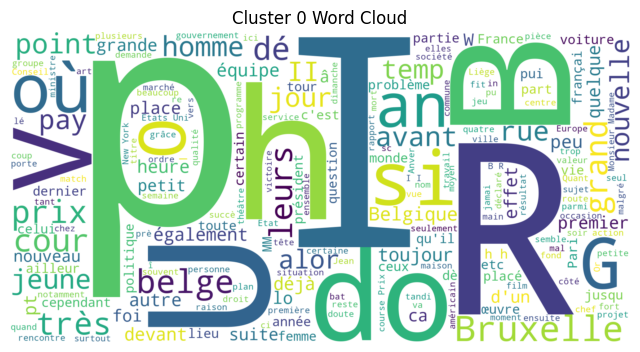

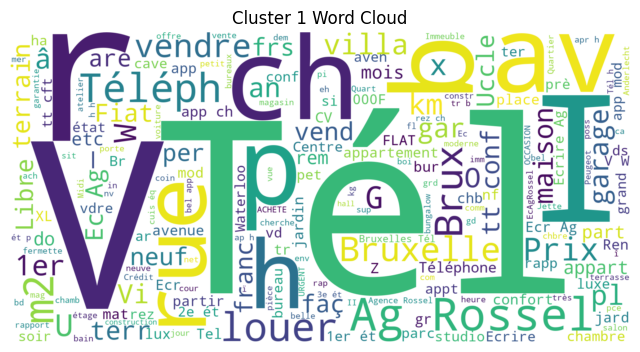

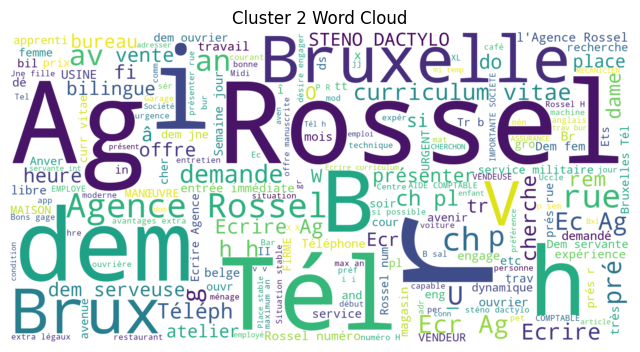

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Supposons que vous avez déjà défini N_CLUSTERS, km_model, tfidf_vectors, et reduced_vectors
# Définir la liste de stopwords
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres","enfin","van","pr","A","F","MN","bon","d'une","k","plat","trè","voir","ver","but","parti","car"
       ,"rien","fin","fr","E","A","là", "fin","li", "lu", "ni", 
       ]
sw = set(sw)

# Créer un dictionnaire pour stocker les textes dans chaque cluster
cluster_texts = {cluster: [] for cluster in range(N_CLUSTERS)}

# Ajouter les textes dans chaque cluster
for idx, label in enumerate(clusters):
    cluster_texts[label].append(texts[idx])

# Créer et afficher le nuage de mots pour chaque cluster
for cluster_label, cluster_text in cluster_texts.items():
    # Concaténer les textes dans le cluster en une seule chaîne
    cluster_text_combined = " ".join(cluster_text)

    # Éliminer les stopwords de la chaîne de texte
    cluster_text_combined = ' '.join([word for word in cluster_text_combined.split() if word.lower() not in sw])
   
    # Créer le nuage de mots avec les stopwords filtrés
    wordcloud = WordCloud(width=2000, height=1000, background_color="white", stopwords=sw).generate(cluster_text_combined)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Cluster {cluster_label} Word Cloud")
    plt.axis("off")
    plt.savefig(f'wordcloudcluster{cluster_label}.png')
    plt.show()


#liste des mot clés pour chacun de nos clusters : les keywords de chaque clusters sont sauvegardés dans un fichier txt

In [ ]:
import collections
import os
import string
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Chargement des données textuelles
data_path = "../data/txt/"
DECADE = '1960'
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]


# Paramètres pour le filtrage
MIN_WORD_LENGTH = 3  # Longueur minimale d'un mot
MAX_WORD_LENGTH = 10  # Longueur maximale d'un mot
POS_TAGS_TO_INCLUDE = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}  # Noms et verbes

# Fonction pour filtrer les mots en fonction de la longueur et de la partie du discours
def is_informative_word(word, pos):
    return MIN_WORD_LENGTH <= len(word) <= MAX_WORD_LENGTH and pos in POS_TAGS_TO_INCLUDE

# Pré-traitement et vectorisation
def preprocessing(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    return tokens

custom_stopwords = set(stopwords.words('french')) | {"1/2", "mn", "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "pr", "ag", "ecr", "1.", "3/4", "1/4", "2", "3.", "dem", "fem"}

# Convertir l'ensemble de stopwords en liste
custom_stopwords_list = list(custom_stopwords)

# Configuration de TfidfVectorizer
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=custom_stopwords_list,
    max_df=0.5,
    min_df=0.1,
    lowercase=True
)

tfidf_vectors = vectorizer.fit_transform(texts)

# Clustering
N_CLUSTERS = 3
km_model = KMeans(n_clusters=N_CLUSTERS)
clusters = km_model.fit_predict(tfidf_vectors)

# Calcul de la moyenne TF-IDF pour chaque cluster
cluster_mean = []
for i in range(N_CLUSTERS):
    cluster_docs = tfidf_vectors[np.where(clusters == i)]
    cluster_mean.append(np.mean(cluster_docs, axis=0))

# Obtention des noms des caractéristiques (mots) du vectoriseur TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Extraction et enregistrement des mots-clés pour chaque cluster
for i in range(N_CLUSTERS):
    mean_array = np.asarray(cluster_mean[i]).flatten()
    sorted_indices = np.argsort(mean_array)[::-1]

    keywords = [feature_names[idx] for idx in sorted_indices][:20]  # Top 20 mots-clés

    with open(f'keywords_cluster_{i+1}.txt', 'w', encoding='utf-8') as file:
        file.write('\n'.join(keywords))
        print(f'Mots-clés pour le cluster {i+1} enregistrés dans keywords_cluster_{i+1}.txt')
